# [CNN]-[MNIST] - Simple Classification with Convolutional Neural Networks

This Kaggle notebook provides a step-by-step implementation of a simple classification task using convolutional neural networks (CNNs) on the popular MNIST dataset.

MNIST is one of the most historic dataset.  
- Include in [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

The notebook is organized into three distinct sections:

## Objectives
In this section, the specific objectives of the notebook are outlined. The main goals include:

- Training a DNN model to accurately recognize handwritten numbers.


## Implementation
This section focuses on the practical implementation steps involved in achieving the objectives mentioned earlier. The implementation steps include:

1. Data Retrieval: Obtaining the MNIST dataset for training and testing.
2. Data Preparation: Preprocessing and preparing the dataset for training the CNN model.
3. Model Creation: Designing and building the CNN model using Keras.
4. Model Training: Training the CNN model using the prepared dataset.
5. Evaluation: Assessing the performance of the trained model and evaluating the classification results.

## Step 1 - Imports & Constants & Methods

### Step 1.1 - Imports

In [13]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import sys,os

from importlib import reload

import math
import sklearn.metrics
import itertools
from sklearn.preprocessing import MinMaxScaler

!pip install visualkeras

import visualkeras

Verbosity during training:
- 0: Silent mode, no output will be displayed during training.
- 1: Progress bar mode, a progress bar will be displayed to show the progress of each epoch.
- 2: One line per epoch mode, a concise summary will be displayed for each epoch.

For the current training configuration:
- Batch size: 512, which determines the number of samples processed in each training iteration.
- Number of epochs: 16, indicating the total number of times the model will be trained on the entire dataset.


### Step 1.2 - Constants

In [14]:
fit_verbosity = 1

batch_size  = 512
epochs      =  16

### Step 1.3 - Methods

In [15]:
def show_images(
    images, 
    labels=None, 
    indices='all', 
    columns=12, 
    figure_size=(1, 1),                
    show_colorbar=False, 
    y_pred=None, 
    color_map='binary',
    normalization=None, 
    padding=0.35, 
    spines_alpha=1, 
    font_size=20,
    interpolation='lanczos'
):
    """
    Show a grid of images with labels.

    Args:
        images: The images to display. Shapes must be (-1, lx, ly), (-1, lx, ly, 1), or (-1, lx, ly, 3).
        labels: Real classes or labels associated with the images. (None)
        indices: Indices of images to show or 'all' for all images. ('all')
        columns: Number of columns in the grid. (12)
        figure_size: Size of the figure (width, height). (1, 1)
        show_colorbar: Whether to show the colorbar. (False)
        predicted_labels: Predicted classes associated with the images. (None)
        color_map: Matplotlib color map to use. ('binary')
        normalization: Matplotlib imshow normalization. (None)
        padding: Padding between rows in the grid. (0.35)
        spines_alpha: Alpha value for the spines. (1)
        font_size: Font size in pixels. (20)
        interpolation: Interpolation method for displaying the images. ('lanczos')

    Returns:
        None
    """
    if indices == 'all':
        indices = range(len(images))

    if normalization and len(normalization) == 2:
        normalization = matplotlib.colors.Normalize(vmin=normalization[0], vmax=normalization[1])

    draw_labels = (labels is not None)
    draw_predicted_labels = (y_pred is not None)

    rows = math.ceil(len(indices) / columns)
    fig = plt.figure(figsize=(columns * figure_size[0], rows * (figure_size[1] + padding)))

    n = 1
    for i in indices:
        axs = fig.add_subplot(rows, columns, n)
        n += 1

        # ---- Shape is (lx,ly)
        if len(images[i].shape) == 2:
            xx = images[i]
        # ---- Shape is (lx,ly,n)
        if len(images[i].shape) == 3:
            (lx, ly, lz) = images[i].shape
            if lz == 1:
                xx = images[i].reshape(lx, ly)
            else:
                xx = images[i]

        img = axs.imshow(xx, cmap=color_map, norm=normalization, interpolation=interpolation)

        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)

        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)

        axs.set_yticks([])
        axs.set_xticks([])

        if draw_labels and not draw_predicted_labels:
            axs.set_xlabel(labels[i], fontsize=font_size)
        if draw_labels and draw_predicted_labels:
            if labels[i] != y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({labels[i]})', fontsize=font_size)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(labels[i], fontsize=font_size)

        if show_colorbar:
            fig.colorbar(img, orientation="vertical", shrink=0.65)

    plt.show()

    
def show_history(
    history, 
    figsize=(8,6), 
    plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']}
):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        plt.show()
        
        
def show_confusion_matrix(
    y_true,
    y_pred,
    target_names,
    title='Confusion matrix',
    cmap=None,
    normalize=True,
    figsize=(10, 8),
    digit_format='{:0.2f}'
):
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
        

## Step 2 - Retrieve data
MNIST is one of the most famous historic dataset.  
Include in [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)


## Step 3 - Preparing the data

In [17]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

print('After normalization : Min={}, max={}'.format(x_train.min(), x_test.max()))

Before normalization : Min=0, max=255
After normalization : Min=0.0, max=1.0


## Step 4 - Preview of the data

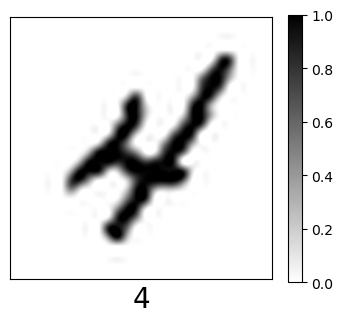

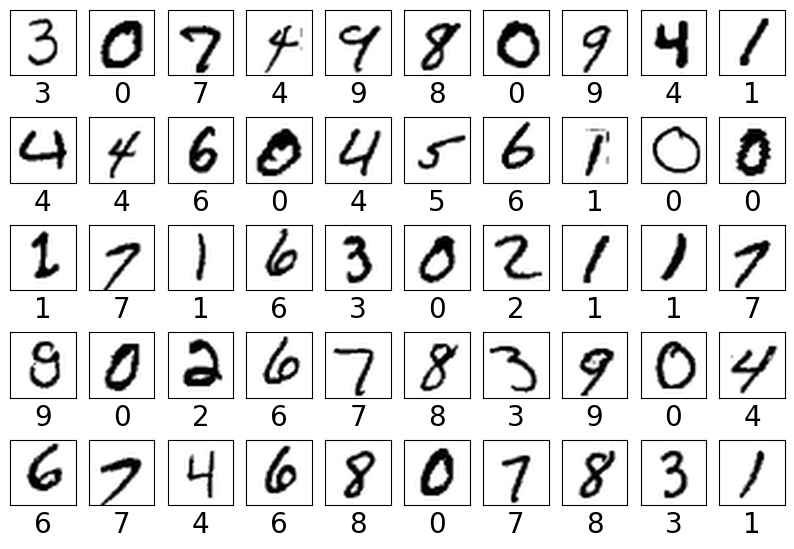

In [18]:
show_images(x_train, y_train, [9], figure_size = (5,5 ), show_colorbar=True)
show_images(x_train, y_train, range(50,100), columns=10)

## Step 4 - Create model

Information about:
- [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers): Determines how the model is updated based on the gradients computed during training.
- [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations): Determines the shape of the output from a neural network layer. It adds non-linearity to the model.
- [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses): Measures how different the model's predictions are from the target values. It is used to guide the model's optimization.
- [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics): Measures used to evaluate the performance of the model, such as accuracy, precision, recall, etc.

In [19]:
model = keras.models.Sequential()

model.add( keras.layers.Input((28,28,1)) )

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(100, activation='relu'))
model.add( keras.layers.Dropout(0.5))

model.add( keras.layers.Dense(10, activation='softmax'))

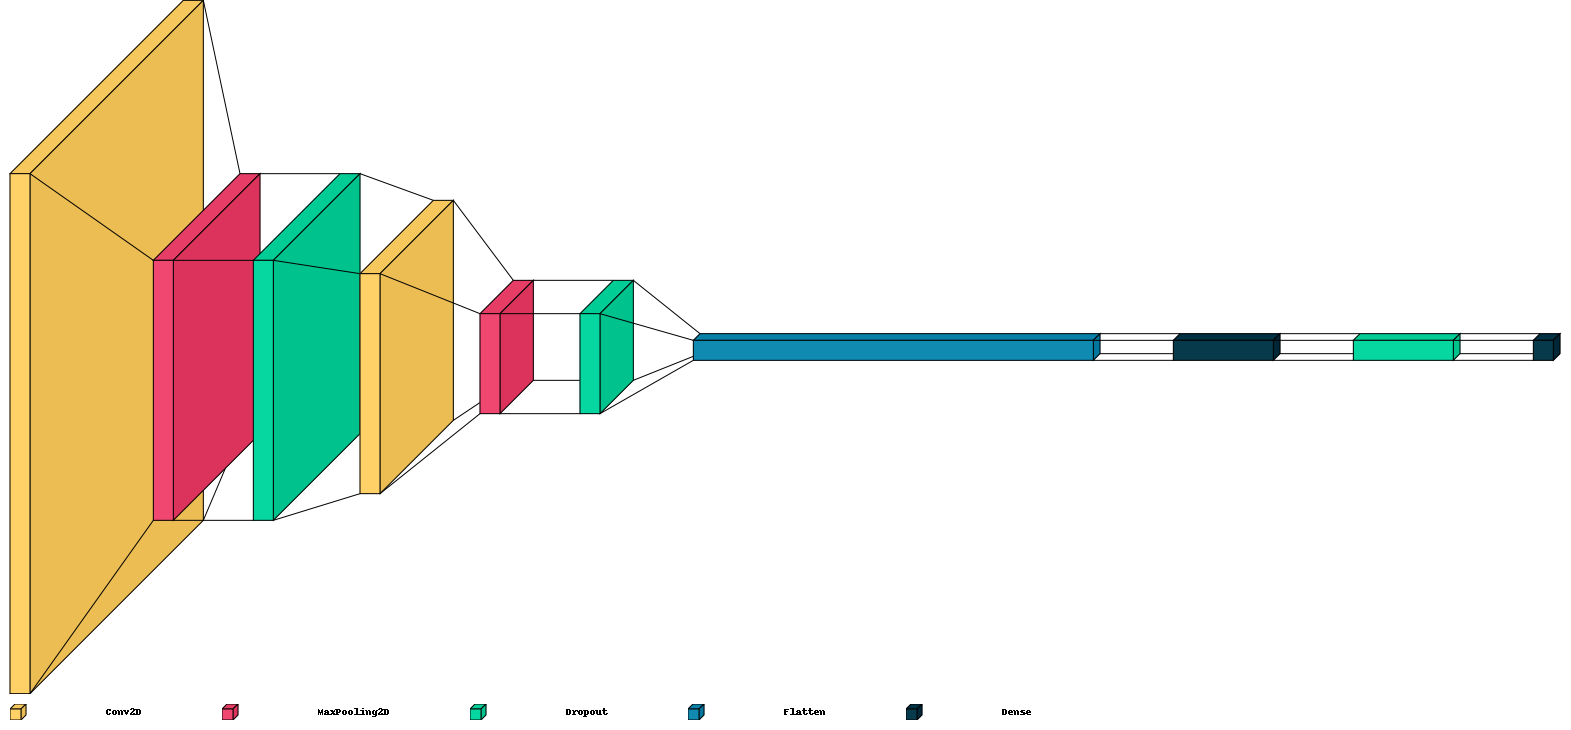

In [20]:
visualkeras.layered_view(model, legend=True, scale_z=1, scale_xy =20, spacing=80)

In [21]:
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

## Step 5 - Train the model

In [22]:
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))

Epoch 1/16
118/118 [==============================] - 13s 97ms/step - loss: 1.1113 - accuracy: 0.6436 - val_loss: 0.2594 - val_accuracy: 0.9346
Epoch 2/16
118/118 [==============================] - 11s 93ms/step - loss: 0.3572 - accuracy: 0.8906 - val_loss: 0.1402 - val_accuracy: 0.9584
Epoch 3/16
118/118 [==============================] - 11s 94ms/step - loss: 0.2563 - accuracy: 0.9219 - val_loss: 0.1074 - val_accuracy: 0.9654
Epoch 4/16
118/118 [==============================] - 11s 91ms/step - loss: 0.2149 - accuracy: 0.9360 - val_loss: 0.0889 - val_accuracy: 0.9731
Epoch 5/16
118/118 [==============================] - 11s 93ms/step - loss: 0.1931 - accuracy: 0.9417 - val_loss: 0.0780 - val_accuracy: 0.9743
Epoch 6/16
118/118 [==============================] - 11s 95ms/step - loss: 0.1734 - accuracy: 0.9488 - val_loss: 0.0698 - val_accuracy: 0.9775
Epoch 7/16
118/118 [==============================] - 10s 89ms/step - loss: 0.1595 - accuracy: 0.9514 - val_loss: 0.0632 - val_accuracy:

## Step 6 - Evaluate
### 6.1 - Final loss and accuracy
Note : With a DNN, we had a precision of the order of : 97.7%

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0404
Test accuracy : 0.9875


### 6.2 - Plot history

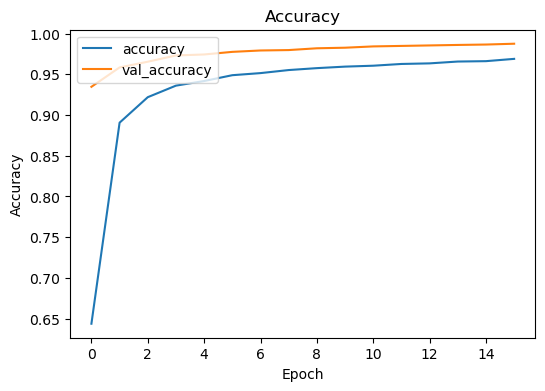

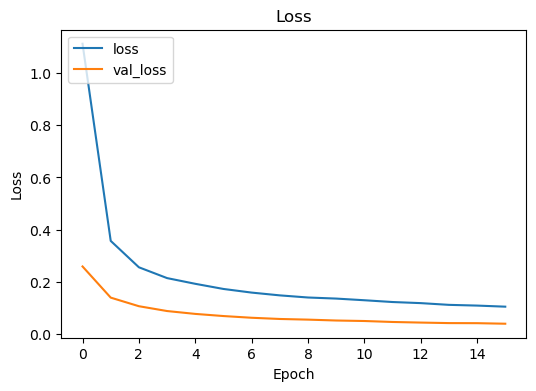

In [24]:
show_history(history, figsize=(6,4))

### 6.3 - Plot results

313/313 [==============================] - 2s 5ms/step


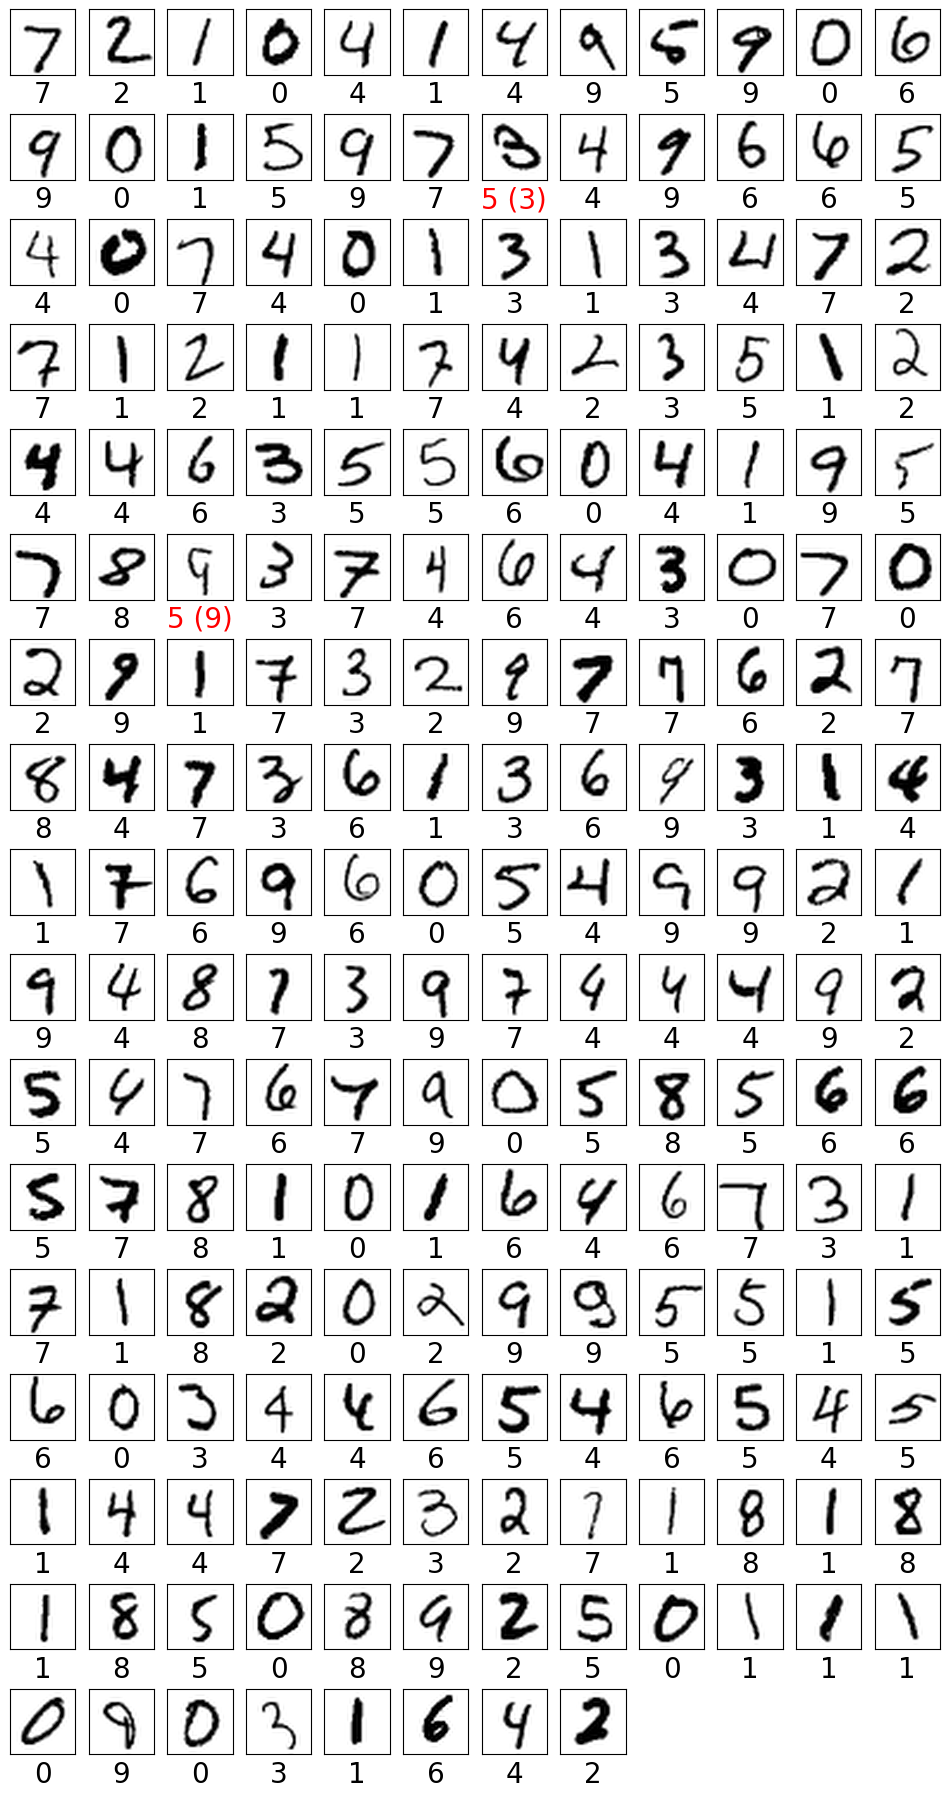

In [25]:
y_probabilities = model.predict(x_test)
y_pred    = np.argmax(y_probabilities, axis=-1)


show_images(x_test, y_test, range(0,200), columns=12, figure_size = (1,1), y_pred=y_pred)

### 6.4 - Plot some errors

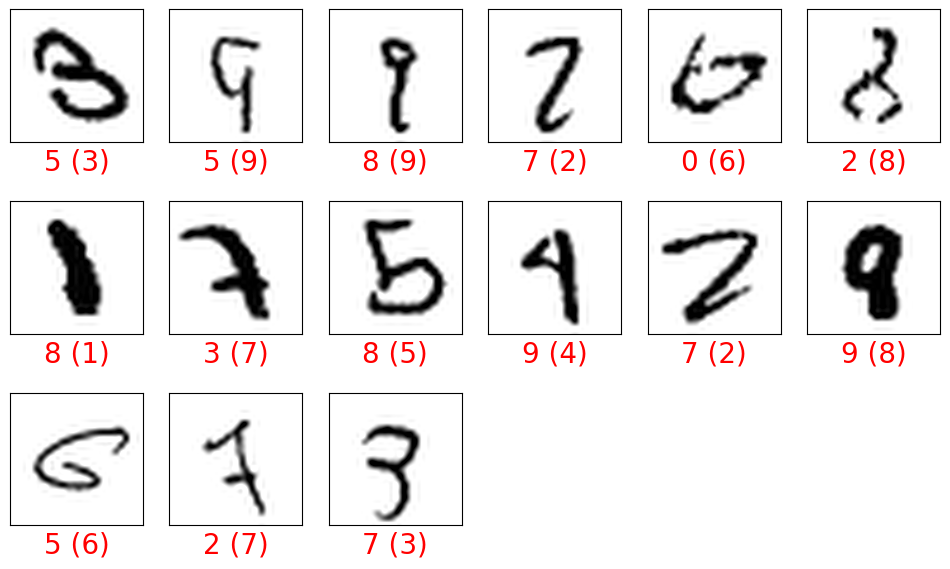

In [26]:
errors=[ i for i in range(len(x_test)) if y_pred[i]!=y_test[i] ]
errors=errors[:min(24,len(errors))]
show_images(x_test, y_test, errors[:15], columns=6, figure_size = (2,2), y_pred=y_pred)

### 6.5 - Confusion Matrix

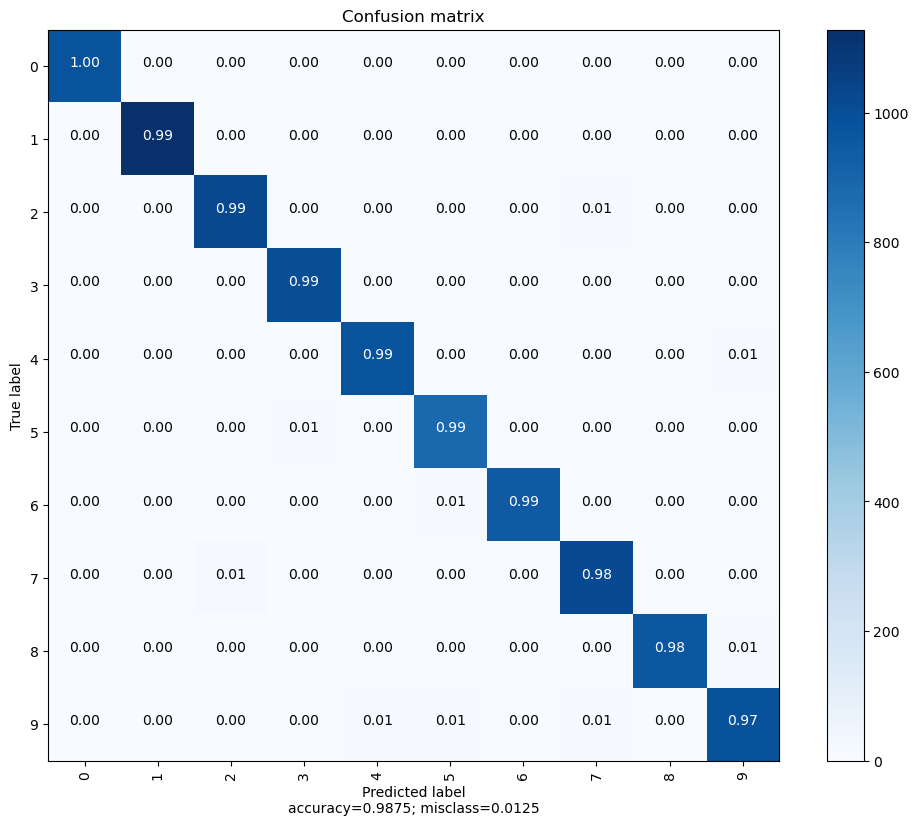

In [27]:
show_confusion_matrix(y_test,y_pred,range(10),normalize=True)